In [80]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

In [81]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [82]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


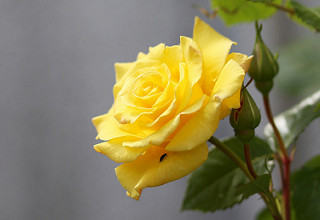

In [83]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [84]:
batch_size = 32
img_height = 180
img_width = 180

In [85]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [86]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [87]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [88]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [89]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [90]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [91]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [93]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 74s 802ms/step - loss: 1.3202 - accuracy: 0.4278 - val_loss: 1.1562 - val_accuracy: 0.5150
Epoch 2/10
92/92 [==============================] - 73s 790ms/step - loss: 0.9859 - accuracy: 0.6104 - val_loss: 0.9761 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 69s 746ms/step - loss: 0.7888 - accuracy: 0.6982 - val_loss: 0.9717 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 63s 680ms/step - loss: 0.5528 - accuracy: 0.7970 - val_loss: 0.9899 - val_accuracy: 0.6267
Epoch 5/10
92/92 [==============================] - 79s 866ms/step - loss: 0.3470 - accuracy: 0.8839 - val_loss: 1.2204 - val_accuracy: 0.6253
Epoch 6/10
92/92 [==============================] - 71s 771ms/step - loss: 0.2122 - accuracy: 0.9346 - val_loss: 1.3513 - val_accuracy: 0.6172
Epoch 7/10
92/92 [==============================] - 72s 784ms/step - loss: 0.1143 - accuracy: 0.9676 - val_loss: 1.5320 - val_accuracy: 0.6553

In [94]:
test_loss, test_acc = model.evaluate(train_ds, verbose=2)
print(f"Presición del {test_acc * 100}%")

92/92 - 17s - loss: 0.0062 - accuracy: 0.9997 - 17s/epoch - 183ms/step
Presición del 99.96594190597534%


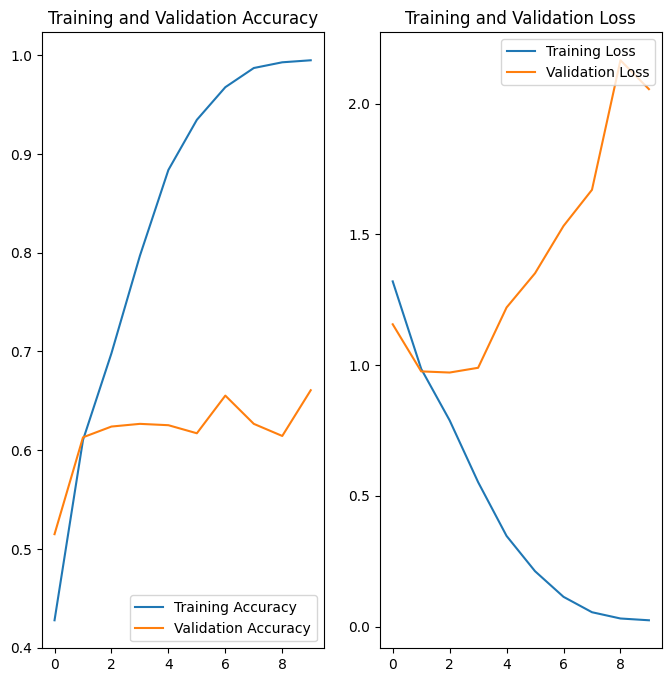

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [98]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [100]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 72s 773ms/step - loss: 1.2382 - accuracy: 0.4765 - val_loss: 1.1746 - val_accuracy: 0.5504
Epoch 2/15
92/92 [==============================] - 73s 790ms/step - loss: 1.0208 - accuracy: 0.5943 - val_loss: 1.0043 - val_accuracy: 0.5886
Epoch 3/15
92/92 [==============================] - 68s 743ms/step - loss: 0.9131 - accuracy: 0.6458 - val_loss: 1.0155 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 70s 758ms/step - loss: 0.8415 - accuracy: 0.6757 - val_loss: 0.9793 - val_accuracy: 0.6267
Epoch 5/15
92/92 [==============================] - 79s 861ms/step - loss: 0.8013 - accuracy: 0.6996 - val_loss: 0.8474 - val_accuracy: 0.6703
Epoch 6/15
92/92 [==============================] - 120s 1s/step - loss: 0.7468 - accuracy: 0.7153 - val_loss: 0.7745 - val_accuracy: 0.6866
Epoch 7/15
92/92 [==============================] - 147s 2s/step - loss: 0.7193 - accuracy: 0.7204 - val_loss: 0.7954 - val_accuracy: 0.7057
Epo

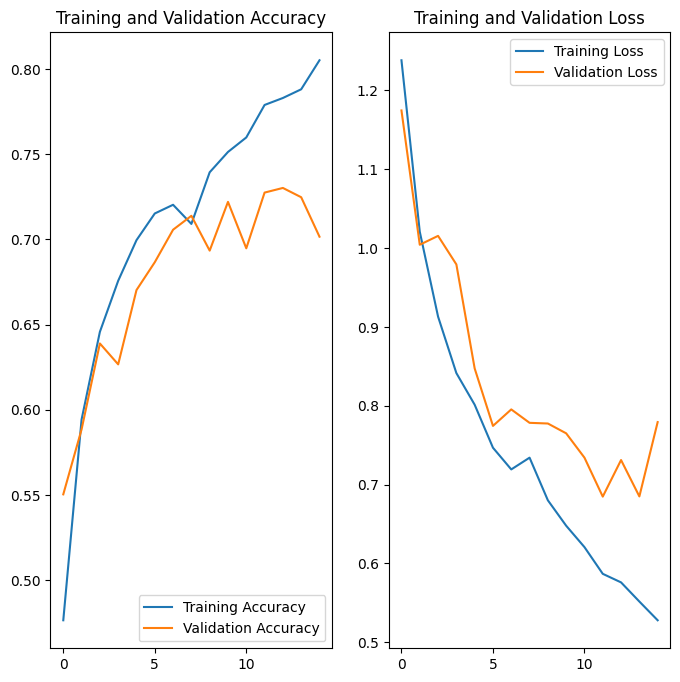

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [104]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)] , 100 * np.max(score))

sunflowers 98.95955920219421


In [105]:
img2 = tf.keras.utils.load_img("./rosasrojas.jpg" , target_size=(img_height, img_width))
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions2 = model.predict(img_array2)
score2 = tf.nn.softmax(predictions2[0])
print(class_names[np.argmax(score2)] , 100 * np.max(score2))


roses 60.91683506965637
